In [15]:
import os 
import sys 
sys.path.append("../src")

from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from src.utils import seed, train
from src.GatedLinear import GatedLinear

In [16]:
np.__version__

'1.19.2'

In [17]:
torch.__version__

'1.6.0'

In [18]:
class ExperimentOneTask:
    def __init__(self, weights, bias=None, input_range=None):
        self.in_features = weights.shape[1]
        self.weights = weights
        self.bias = bias
        self.input_range = input_range
        
    def sample(self, count: int) -> torch.Tensor:
        with torch.no_grad():
            xs = torch.randn(count, self.in_features).float()
            if self.input_range is not None:
                xs = torch.clamp(xs, *self.input_range)
            ys = F.linear(xs, self.weights, self.bias)
            return xs, ys

In [19]:
class ExperimentOneGenerator:
    def __init__(self, in_features, out_features, input_range: Tuple[int, int] = None, bias=True, mask_proba: float=0.5):
        self.in_features = in_features
        self.out_features = out_features
        self.input_range = input_range
        self.has_bias = bias
        self.mask_proba = mask_proba
        
        self.weights = np.random.uniform(size=(self.out_features, self.in_features))
        if self.has_bias:
            self.bias = np.random.uniform(size=(self.out_features,))
            
    def createTask(self):
        weight_mask = np.random.uniform(size=(self.out_features, self.in_features)) < self.mask_proba
        task_weights = torch.from_numpy(self.weights * weight_mask).float()
        
        if self.has_bias:
            bias_mask = np.random.uniform(size=(self.out_features, )) < self.mask_proba
            task_bias = torch.from_numpy(self.bias * bias_mask).float()
        else:
            task_bias = None
            
        return ExperimentOneTask(task_weights, task_bias, self.input_range)

# Plot the Data

In [20]:
gen1 = ExperimentOneGenerator(2, 1)
seed(1) 
task1 = gen1.createTask() # currently has second variable 'turned off'
task2 = gen1.createTask() # both variables on

In [21]:
train1x, train1y = task1.sample(50)
train2x, train2y = task2.sample(50)

In [22]:
task1.weights, task1.bias

(tensor([[0.6504, 0.0000]]), tensor([0.5877]))

In [23]:
task2.weights, task2.bias

(tensor([[0.6504, 0.8022]]), tensor([0.5877]))

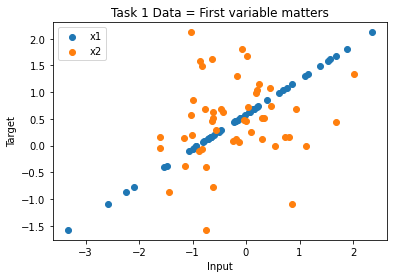

In [24]:
plt.title("Task 1 Data = First variable matters")
plt.scatter(train1x[:,0], train1y)
plt.scatter(train1x[:,1], train1y)
plt.xlabel("Input")
plt.ylabel("Target")
plt.legend(["x1", "x2"])

### One looks like complete noise, the other is perfect fit

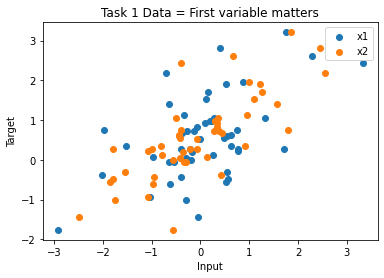

In [25]:
plt.title("Task 1 Data = First variable matters")
plt.scatter(train2x[:,0], train2y)
plt.scatter(train2x[:,1], train2y)
plt.xlabel("Input")
plt.ylabel("Target")
plt.legend(["x1", "x2"])

### Both are somewhat fits, but the variable that was previously stronger is no longer perfect fit

In [42]:
np.random.seed(0)
exp1 = ExperimentOneGenerator(5, 1, mask_proba=0.5)
tasks = [exp1.createTask() for _ in range(20)]
trainsets = [task.sample(5000) for task in tasks]
testsets = [task.sample(5000) for task in tasks]

In [43]:
make_model = lambda : GatedLinear(5, 1)
make_optim = lambda params: Adam(params, lr=3e-4)
criterion = nn.MSELoss()

In [44]:
models, optims, losses = train(
    make_model,
    make_optim,
    tasks=trainsets, criterion=criterion,
    n_epochs=200000)

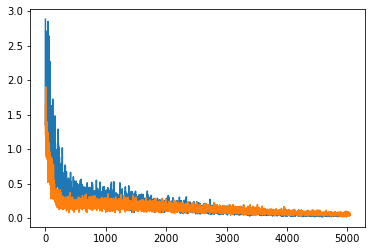

In [38]:
plt.plot(losses[0])
plt.plot(losses[1])

In [39]:
for n in range(len(tasks)):
    print(f"task {n} raw weights", models[n].WW)
    print(f"task {n} computed weights: ", GatedLinear.gated(models[n].WW, models[n].WM))
    print(f"task {n} correct weights: ", tasks[n].weights)
    print("====================")

task 0 raw weights Parameter containing:
tensor([[0.5890, 0.8699]], requires_grad=True)
task 0 computed weights:  tensor([[0.1343, 0.6134]], grad_fn=<MulBackward0>)
task 0 correct weights:  tensor([[0.0000, 0.7152]])
task 1 raw weights Parameter containing:
tensor([[0.5890, 0.8699]], requires_grad=True)
task 1 computed weights:  tensor([[0.4401, 0.1891]], grad_fn=<MulBackward0>)
task 1 correct weights:  tensor([[0.5488, 0.0000]])
task 2 raw weights Parameter containing:
tensor([[0.5890, 0.8699]], requires_grad=True)
task 2 computed weights:  tensor([[0.4388, 0.1914]], grad_fn=<MulBackward0>)
task 2 correct weights:  tensor([[0.5488, 0.0000]])
task 3 raw weights Parameter containing:
tensor([[0.5890, 0.8699]], requires_grad=True)
task 3 computed weights:  tensor([[0.1368, 0.1967]], grad_fn=<MulBackward0>)
task 3 correct weights:  tensor([[0., 0.]])
task 4 raw weights Parameter containing:
tensor([[0.5890, 0.8699]], requires_grad=True)
task 4 computed weights:  tensor([[0.4354, 0.6154]],

In [40]:
for n in range(len(tasks)):
    print(f"task {n} mask: ", torch.sigmoid(models[n].WM))
    print(f"task {n} correct mask: ", (tasks[n].weights != 0).float())

task 0 mask:  tensor([[0.2280, 0.7052]], grad_fn=<SigmoidBackward>)
task 0 correct mask:  tensor([[0., 1.]])
task 1 mask:  tensor([[0.7472, 0.2174]], grad_fn=<SigmoidBackward>)
task 1 correct mask:  tensor([[1., 0.]])
task 2 mask:  tensor([[0.7449, 0.2200]], grad_fn=<SigmoidBackward>)
task 2 correct mask:  tensor([[1., 0.]])
task 3 mask:  tensor([[0.2323, 0.2261]], grad_fn=<SigmoidBackward>)
task 3 correct mask:  tensor([[0., 0.]])
task 4 mask:  tensor([[0.7391, 0.7074]], grad_fn=<SigmoidBackward>)
task 4 correct mask:  tensor([[1., 1.]])
task 5 mask:  tensor([[0.2170, 0.2223]], grad_fn=<SigmoidBackward>)
task 5 correct mask:  tensor([[0., 0.]])
task 6 mask:  tensor([[0.2273, 0.7076]], grad_fn=<SigmoidBackward>)
task 6 correct mask:  tensor([[0., 1.]])
task 7 mask:  tensor([[0.7334, 0.2322]], grad_fn=<SigmoidBackward>)
task 7 correct mask:  tensor([[1., 0.]])
task 8 mask:  tensor([[0.2361, 0.2289]], grad_fn=<SigmoidBackward>)
task 8 correct mask:  tensor([[0., 0.]])
task 9 mask:  tenso